# NVIDIA Chip Estimates (v2 - Functional Sampling)

This notebook uses a functional sampling architecture where `nvidia_sample()` returns a single sample of chip counts for all quarters and chips, with correlated parameters:
- **Hardware share**: Sampled once per `nvidia_sample()` call (correlated across quarters)
- **Base prices**: Sampled once per chip, with deflation applied deterministically

This gives wider, more realistic confidence intervals for cumulative totals compared to independent sampling.

In [1]:
import squigglepy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

In [2]:
# NVIDIA chip specs: 8-bit TFLOP/s
CHIP_SPECS = {
    'A100':      {'tops': 624},
    'A800':      {'tops': 624},
    'H100/H200': {'tops': 1979},
    'H800':      {'tops': 1979},
    'H20':       {'tops': 296},
    'B200':      {'tops': 5000},
    'B300':      {'tops': 5000},
}
CHIP_TYPES = list(CHIP_SPECS.keys())

# Colors for visualization
CHIP_COLORS = {
    'A100': 'lightcoral',
    'A800': 'sienna',
    'H100/H200': 'steelblue',
    'H800': 'firebrick',
    'H20': 'orange',
    'B200': 'mediumseagreen',
    'B300': 'seagreen',
}

# Hardware share of compute revenue (vs cloud/software)
HARDWARE_SHARE = sq.to(0.96, 0.99, credibility=80)

In [3]:
# Load revenue and price data from Google Sheets
revenue_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0"
).set_index('Quarter')

prices_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
).set_index('Year')

QUARTERS = revenue_df.index.tolist()

revenue_df[['Compute revenue'] + [f'{chip} share' for chip in CHIP_TYPES]].head()

,Compute revenue,A100 share,A800 share,H100/H200 share,H800 share,H20 share,B200 share,B300 share
Quarter,,,,,,,,
FY23Q1,2.81,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q2,2.86,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q3,2.87,0.90,0.00,0.1,0.0,0.0,0.0,0.0
FY23Q4,2.72,0.31,0.19,0.5,0.0,0.0,0.0,0.0
FY24Q1,3.35,0.21,0.09,0.6,0.1,0.0,0.0,0.0


In [4]:
# Price setup: base prices with deflation over time
PRICE_COLUMN_MAP = {'H100/H200': 'H100'}
FALLBACK_PRICES = {
    'A100': (10*K, 15*K), 'A800': (10*K, 15*K), 'H100/H200': (20*K, 30*K),
    'H800': (20*K, 30*K), 'H20': (10*K, 15*K), 'B200': (33*K, 42*K), 'B300': (33*K, 42*K)
}

def get_price_bounds(chip, year):
    """Get (low, high) price bounds for a chip in a given year, or None."""
    col = PRICE_COLUMN_MAP.get(chip, chip)
    low_col, high_col = f'{col} low', f'{col} high'
    if low_col in prices_df.columns and year in prices_df.index:
        low, high = prices_df.loc[year, low_col], prices_df.loc[year, high_col]
        if pd.notna(low) and pd.notna(high):
            return (low, high)
    return None

def find_base_year(chip):
    """Find the first year with price data for a chip."""
    col = PRICE_COLUMN_MAP.get(chip, chip)
    low_col = f'{col} low'
    if low_col in prices_df.columns:
        for year in sorted(prices_df.index):
            if pd.notna(prices_df.loc[year, low_col]):
                return year
    return min(prices_df.index)

# Build base prices (first year available for each chip)
BASE_YEAR = {chip: find_base_year(chip) for chip in CHIP_TYPES}
BASE_PRICES = {chip: sq.to(*(get_price_bounds(chip, BASE_YEAR[chip]) or FALLBACK_PRICES[chip]), credibility=80) 
               for chip in CHIP_TYPES}

def get_deflation_factor(quarter, chip):
    """Ratio of current to base price (geometric means)."""
    price_year = pd.to_datetime(revenue_df.loc[quarter, 'Start Date']).year
    if price_year <= BASE_YEAR[chip]:
        return 1.0
    base = get_price_bounds(chip, BASE_YEAR[chip])
    curr = get_price_bounds(chip, price_year)
    if base and curr:
        return np.sqrt(curr[0] * curr[1]) / np.sqrt(base[0] * base[1])
    return 1.0

print("Base years:", {c: BASE_YEAR[c] for c in CHIP_TYPES if get_price_bounds(c, BASE_YEAR[c])})

Base years: {'A100': 2022, 'A800': 2022, 'H100/H200': 2022, 'H800': 2023, 'H20': 2024, 'B200': 2024, 'B300': 2025}


In [5]:
def nvidia_sample():
    """Sample chip counts for all quarters/chips. Correlated: hardware_share and base_prices sampled once."""
    hardware_share = HARDWARE_SHARE @ 1
    base_prices = {chip: BASE_PRICES[chip] @ 1 for chip in CHIP_TYPES}

    result = {}
    for quarter in QUARTERS:
        result[quarter] = {}
        revenue = revenue_df.loc[quarter, 'Compute revenue'] * B * hardware_share
        for chip in CHIP_TYPES:
            share = revenue_df.loc[quarter, f'{chip} share']
            if pd.notna(share) and share > 0:
                price = base_prices[chip] * get_deflation_factor(quarter, chip)
                result[quarter][chip] = revenue * share / price
            else:
                result[quarter][chip] = 0.0
    return result

In [6]:
# Aggregation helpers
def cumulative_by_chip(sample):
    """Sum sample across all quarters, by chip."""
    return {chip: sum(sample[q][chip] for q in sample) for chip in CHIP_TYPES}

def total_chips(sample):
    """Sum sample across all quarters and chips."""
    return sum(cumulative_by_chip(sample).values())

In [7]:
# Interval helpers using sq.get_percentiles
def get_quarterly_intervals(samples):
    """Extract {quarter: {chip: {5: x, 50: y, 95: z}}} from samples."""
    return {q: {c: sq.get_percentiles([s[q][c] for s in samples], percentiles=[5, 50, 95]) 
                for c in CHIP_TYPES} for q in QUARTERS}

def get_chip_intervals(samples):
    """Extract {chip: {5: x, 50: y, 95: z}} from cumulative samples."""
    return {c: sq.get_percentiles([s[c] for s in samples], percentiles=[5, 50, 95]) for c in CHIP_TYPES}

In [8]:
# Collect samples
quarterly_samples = sq.sample(nvidia_sample, n=N_SAMPLES)
quarterly_intervals = get_quarterly_intervals(quarterly_samples)

cumulative_samples = sq.sample(lambda: cumulative_by_chip(nvidia_sample()), n=N_SAMPLES)
cumulative_intervals = get_chip_intervals(cumulative_samples)

total_samples = sq.sample(lambda: total_chips(nvidia_sample()), n=N_SAMPLES)
total_intervals = sq.get_percentiles(total_samples, percentiles=[5, 50, 95])

print(f"Collected {N_SAMPLES} samples.")

Collected 5000 samples.


In [9]:
# Quarterly summary by chip type
print("=== QUARTERLY CHIP SALES BY TYPE ===\n")
for chip in CHIP_TYPES:
    if not any(quarterly_intervals[q][chip][50] > 0 for q in QUARTERS):
        continue
    print(f"--- {chip} ---")
    print(f"{'Quarter':<10} {'Units (p50)':>12} {'Units (90% CI)':>24}")
    for q in QUARTERS:
        s = quarterly_intervals[q][chip]
        if s[50] > 0:
            ci = f"({int(s[5]):,} - {int(s[95]):,})"
            print(f"{q:<10} {int(s[50]):>12,} {ci:>24}")
    print()

=== QUARTERLY CHIP SALES BY TYPE ===

--- A100 ---
Quarter     Units (p50)           Units (90% CI)
FY23Q1          222,935      (171,337 - 288,816)
FY23Q2          226,902      (174,385 - 293,955)
FY23Q3          204,926      (157,496 - 265,485)
FY23Q4           66,896        (51,413 - 86,665)
FY24Q1           55,813        (42,895 - 72,306)
FY24Q2           68,308        (52,498 - 88,495)
FY24Q3           47,205        (36,279 - 61,155)

--- A800 ---
Quarter     Units (p50)           Units (90% CI)
FY23Q4           41,106        (31,448 - 53,638)
FY24Q1           23,981        (18,347 - 31,292)
FY24Q2           27,393        (20,957 - 35,745)
FY24Q3           28,396        (21,724 - 37,052)

--- H100/H200 ---
Quarter     Units (p50)           Units (90% CI)
FY23Q3            9,115         (7,685 - 10,776)
FY23Q4           43,195        (36,417 - 51,067)
FY24Q1           63,840        (53,823 - 75,474)
FY24Q2          194,161      (163,695 - 229,545)
FY24Q3          287,251      (242,

In [10]:
# Cumulative summary
print("Cumulative NVIDIA Chip Sales")
print(f"{'Chip':<12} {'p5':>12} {'p50':>12} {'p95':>12}")
print("-" * 51)
for chip in CHIP_TYPES:
    s = cumulative_intervals[chip]
    if s[50] > 0:
        print(f"{chip:<12} {int(s[5]):>12,} {int(s[50]):>12,} {int(s[95]):>12,}")
print("-" * 51)
print(f"{'TOTAL':<12} {int(total_intervals[5]):>12,} {int(total_intervals[50]):>12,} {int(total_intervals[95]):>12,}")

Cumulative NVIDIA Chip Sales
Chip                   p5          p50          p95
---------------------------------------------------
A100              697,268      897,659    1,167,065
A800               93,133      121,729      156,793
H100/H200       3,648,639    4,311,667    5,114,834
H800               93,509      116,656      144,287
H20             1,157,567    1,495,379    1,949,243
B200            1,369,741    1,602,645    1,863,763
B300              794,794      939,049    1,103,752
---------------------------------------------------
TOTAL           8,651,062    9,536,228   10,520,928


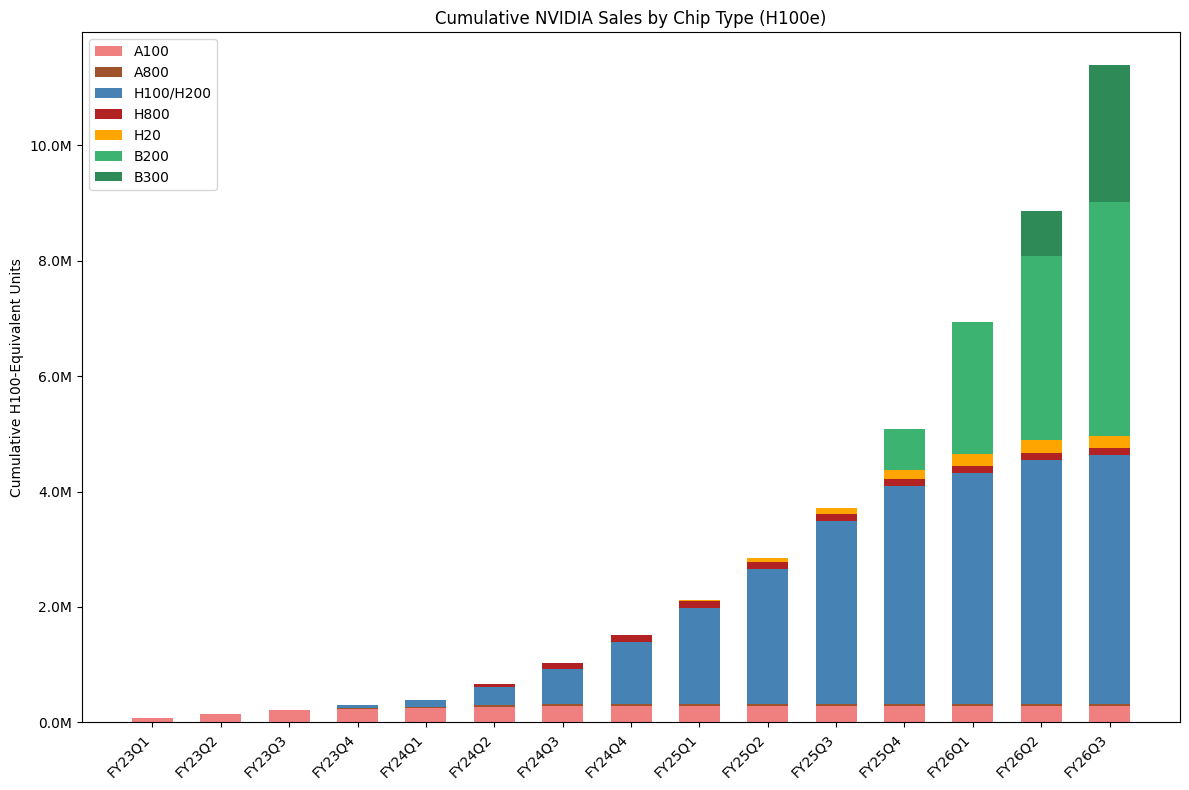

In [11]:
# Cumulative chart (H100-equivalent units)
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(QUARTERS))
bottom = np.zeros(len(QUARTERS))

for chip in CHIP_TYPES:
    h100e_ratio = CHIP_SPECS[chip]['tops'] / H100_TOPS
    medians = np.array([quarterly_intervals[q][chip][50] for q in QUARTERS]) * h100e_ratio
    cumulative = np.cumsum(medians)
    ax.bar(x, cumulative, 0.6, label=chip, bottom=bottom, color=CHIP_COLORS[chip])
    bottom += cumulative

ax.set_ylabel('Cumulative H100-Equivalent Units')
ax.set_title('Cumulative NVIDIA Sales by Chip Type (H100e)')
ax.set_xticks(x)
ax.set_xticklabels(QUARTERS, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1e6:.1f}M'))
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
# Convert to legacy format for export/interpolation
sim_results = {q: {c: np.array([s[q][c] for s in quarterly_samples]) for c in CHIP_TYPES} for q in QUARTERS}

In [13]:
# Export fiscal quarter results
from datetime import datetime
generated_note = f"Estimates generated on: {datetime.now().strftime('%m-%d-%Y %H:%M')}"

rows = []
for quarter in QUARTERS:
    for chip in CHIP_TYPES:
        arr = sim_results[quarter][chip]
        if arr.sum() > 0:
            u_p5, u_p50, u_p95 = [int(np.percentile(arr, p)) for p in [5, 50, 95]]
            h100e = CHIP_SPECS[chip]['tops'] / H100_TOPS
            rows.append({
                'Name': f"{quarter} - {'H100' if chip == 'H100/H200' else chip}",
                'Chip manufacturer': 'Nvidia',
                'Start date': revenue_df.loc[quarter, 'Start Date'],
                'End date': revenue_df.loc[quarter, 'End Date'],
                'Compute estimate in H100e (median)': int(u_p50 * h100e),
                'H100e (5th percentile)': int(u_p5 * h100e),
                'H100e (95th percentile)': int(u_p95 * h100e),
                'Number of Units': u_p50,
                'Number of Units (5th percentile)': u_p5,
                'Number of Units (95th percentile)': u_p95,
                'Notes': generated_note,
                'Chip type': 'H100' if chip == 'H100/H200' else chip,
            })

nvidia_chip_timelines = pd.DataFrame(rows)
nvidia_chip_timelines.to_csv('nvidia_chip_timelines.csv', index=False)
print(f"Exported {len(rows)} rows to nvidia_chip_timelines.csv")

Exported 39 rows to nvidia_chip_timelines.csv


In [14]:
# Interpolate to calendar quarters
from chip_estimates_utils import interpolate_to_calendar_quarters, summarize_calendar_quarters

quarter_dates = {q: (revenue_df.loc[q, 'Start Date'], revenue_df.loc[q, 'End Date']) for q in QUARTERS}
calendar_results = interpolate_to_calendar_quarters(sim_results, quarter_dates, verbose=False)

print("Calendar Quarter Summary:")
print(summarize_calendar_quarters(calendar_results).to_string(index=False))

Calendar Quarter Summary:
Quarter             A100          A800        H100/H200          H800              H20             B200             B300               Total
Q1 2022 147k (113k-190k)             -                -             -                -                -                -    147k (113k-190k)
Q2 2022 226k (173k-292k)             -                -             -                -                -                -    226k (173k-292k)
Q3 2022 215k (165k-278k)             -       6k (5k-7k)             -                -                -                -    221k (170k-285k)
Q4 2022  113k (87k-147k) 28k (21k-37k)    32k (27k-38k)             -                -                -                -    174k (136k-221k)
Q1 2023    59k (45k-76k) 29k (22k-38k)    57k (48k-67k)    7k (6k-9k)                -                -                -    152k (121k-190k)
Q2 2023    64k (49k-83k) 26k (20k-34k) 151k (127k-179k) 32k (26k-40k)                -                -                -    274k

In [15]:
# Export calendar quarter results
nvidia_start = pd.to_datetime(revenue_df['Start Date'].iloc[0])
nvidia_end = pd.to_datetime(revenue_df['End Date'].iloc[-1])

def cal_quarter_dates(cal_q):
    """Return (start, end) for calendar quarter like 'Q1 2024'."""
    q, year = int(cal_q[1]), int(cal_q.split()[1])
    starts = {1: f"1/1/{year}", 2: f"4/1/{year}", 3: f"7/1/{year}", 4: f"10/1/{year}"}
    ends = {1: f"3/31/{year}", 2: f"6/30/{year}", 3: f"9/30/{year}", 4: f"12/31/{year}"}
    return starts[q], ends[q]

rows = []
for quarter in calendar_results:
    start, end = cal_quarter_dates(quarter)
    cal_start, cal_end = pd.to_datetime(start, format='%m/%d/%Y'), pd.to_datetime(end, format='%m/%d/%Y')
    
    # Check if incomplete
    incomplete = None
    if cal_start < nvidia_start:
        incomplete = f"Incomplete: fiscal data starts {nvidia_start.month}/{nvidia_start.day}/{nvidia_start.year}"
    if cal_end > nvidia_end:
        incomplete = f"Incomplete: fiscal data ends {nvidia_end.month}/{nvidia_end.day}/{nvidia_end.year}"
    
    for chip in CHIP_TYPES:
        s = calendar_results[quarter][chip]
        if s['p50'] > 0:
            h100e = CHIP_SPECS[chip]['tops'] / H100_TOPS
            rows.append({
                'Name': f"{quarter} - {chip}", 'Chip manufacturer': 'Nvidia',
                'Start date': start, 'End date': end,
                'Compute estimate in H100e (median)': int(s['p50'] * h100e),
                'H100e (5th percentile)': int(s['p5'] * h100e),
                'H100e (95th percentile)': int(s['p95'] * h100e),
                'Number of Units': int(s['p50']),
                'Number of Units (5th percentile)': int(s['p5']),
                'Number of Units (95th percentile)': int(s['p95']),
                'Notes': f"{incomplete}. {generated_note}" if incomplete else generated_note,
                'Chip type': chip,
            })

nvidia_timelines_interpolated = pd.DataFrame(rows)
nvidia_timelines_interpolated.to_csv('nvidia_timelines_interpolated.csv', index=False)
print(f"Exported {len(rows)} rows to nvidia_timelines_interpolated.csv")

Exported 46 rows to nvidia_timelines_interpolated.csv
